# Building autoencoder using Pytorch

In [2]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

In [ ]:
!nvidia-smi

Loads Fashion-MNIST with ToTensor(), randomly subsamples 50k training and 5k test images to speed up experiments, and creates SubsetRandomSamplers for feeding those subsets to your DataLoaders.

In [6]:



# Convert data to torch.FloatTensor
transform = transforms.ToTensor()


train_data = datasets.FashionMNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.FashionMNIST(root='data', train=False,
                                   download=True, transform=transform)

# Select only a part of the dataset to speed up training times
num_train_samples = 50000
num_test_samples = 5000

# Randomly select a subset of samples
train_indices = torch.randperm(len(train_data))[:num_train_samples]
test_indices = torch.randperm(len(test_data))[:num_test_samples]

# Create subset samplers to be used in the dataloader
train_subset_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
test_subset_sampler = torch.utils.data.SubsetRandomSampler(test_indices)



Builds PyTorch DataLoaders that iterate over the randomly selected Fashion-MNIST subsets in mini-batches of 32 (via the subset samplers) with num_workers=0, yielding batched tensors for the training and test loops.

In [7]:
# Choose how many samples per batch to load
# You can tune the batch size
batch_size = 32

# Prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size,
                                           sampler = train_subset_sampler,
                                           num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=batch_size,
                                          sampler = test_subset_sampler,
                                          num_workers=0)

Loads NumPy/matplotlib and a helper imshow, grabs one batch from train_loader, takes the first 16 images, arranges them into a 4×4 grid with torchvision.make_grid, converts the tensor to H×W×C for plt.imshow, and displays the grid.

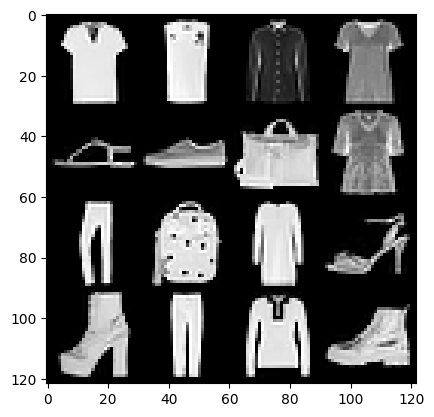

In [9]:
# package we used to manipulate matrix
import numpy as np
# package we used for image processing
from matplotlib import pyplot as plt
from torchvision.utils import make_grid

def imshow(img):
    npimg = img.numpy()
    #transpose: change array axis to correspond to the plt.imshow() function     
    plt.imshow(np.transpose(npimg, (1, 2, 0))) 
    plt.show()

# load the first 16 training samples from next iteration
# [:16,:,:,:] for the 4 dimension of examples, first dimension take first 16, other dimension take all data
# arrange the image in grid
examples, _ = next(iter(train_loader))
example_show=make_grid(examples[:16,:,:,:], 4)

# then display them
imshow(example_show)

Defines a fully connected autoencoder for MNIST that maps flattened 28×28 images (784) → 256 → 128 (latent) → 256 → 784 with sigmoid activations for reconstruction, then instantiates the model and moves it to GPU with model.cuda().

In [10]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Network Parameters
num_hidden_1 = 256  # 1st layer num features
num_hidden_2 = 128  # 2nd layer num features (the latent dim)
num_input = 784  # MNIST data input (img shape: 28*28)


# Building the encoder
class Autoencoder(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2):
        super(Autoencoder, self).__init__()
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        # decoder part
        self.fc3 = nn.Linear(h_dim2, h_dim1)
        self.fc4 = nn.Linear(h_dim1, x_dim)

    def encoder(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

    def decoder(self, x):
        x = torch.sigmoid(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# When initialzing, it will run __init__() function as above
model = Autoencoder(num_input, num_hidden_1, num_hidden_2)
# If using GPU, model need to be set on cuda()
model.cuda()

Autoencoder(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=784, bias=True)
)

Trains the autoencoder for 20 epochs using MSE reconstruction loss and Adam(1e-3): for each mini-batch from train_loader it flattens images to 784, moves them to GPU, zeros grads, does a forward pass, computes loss = MSE(outputs, images), backpropagates, steps the optimizer, accumulates loss, and prints the average training loss per epoch (labels _ are unused).

In [11]:
# Specify the loss function
criterion = nn.MSELoss()

# We use Adam as the optimizer with a fixed learning rate of 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Choose the number of Epochs to train the network
n_epochs = 20
# Set model to training mode
model.train()

for epoch in range(n_epochs):
    # Monitor training loss
    train_loss = 0.0

    # Train the model #
    # Feed the data into the network batch by batch using the dataloader
    for batch_data in train_loader:
        # _ stands in for labels
        # we do not need labels when conducting reconstruction
        images, _ = batch_data
        # Flatten images and send images to GPU
        images = images.view(images.size(0), -1)
        # Send images to GPU if possible
        if torch.cuda.is_available():
          images = images.cuda()
        # Clear the gradients of all optimized variables
        optimizer.zero_grad()
        # Forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # Calculate the loss between output and input images
        loss = criterion(outputs, images)
        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # Perform a single optimization step (parameter update)
        optimizer.step()
        # Update running training loss
        train_loss += loss.item()*images.size(0)

    # Print avg training statistics
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch,
        train_loss
        ))




Epoch: 0 	Training Loss: 1.250567
Epoch: 1 	Training Loss: 0.702907
Epoch: 2 	Training Loss: 0.592148
Epoch: 3 	Training Loss: 0.530931
Epoch: 4 	Training Loss: 0.484968
Epoch: 5 	Training Loss: 0.449377
Epoch: 6 	Training Loss: 0.422527
Epoch: 7 	Training Loss: 0.400259
Epoch: 8 	Training Loss: 0.382404
Epoch: 9 	Training Loss: 0.367401
Epoch: 10 	Training Loss: 0.353845
Epoch: 11 	Training Loss: 0.342332
Epoch: 12 	Training Loss: 0.331591
Epoch: 13 	Training Loss: 0.321678
Epoch: 14 	Training Loss: 0.312862
Epoch: 15 	Training Loss: 0.304709
Epoch: 16 	Training Loss: 0.297412
Epoch: 17 	Training Loss: 0.290540
Epoch: 18 	Training Loss: 0.283956
Epoch: 19 	Training Loss: 0.277577


Sets the model to eval mode, turns off gradients, loops over the test loader to flatten/move images to GPU, runs a forward pass, computes MSE reconstruction loss, accumulates it across batches, averages at the end, and prints the final test loss.
Note: with nn.MSELoss()’s default reduction='mean', either average per batch directly or divide by the total number of elements/samples (not just len(test_loader)) for a true dataset mean.

In [12]:
# Set model to evaluation mode
model.eval()

# Monitor test loss
test_loss = 0.0

# Disable gradient computation
with torch.no_grad():
    # Iterate over the test data
    for batch_data in test_loader:
        # Extract images from the batch
        images, _ = batch_data
        # Flatten images and send them to GPU
        images = images.view(images.size(0), -1)
        # Send to GPU
        if torch.cuda.is_available():
          images = images.cuda()
        # Forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # Calculate the loss between output and input images
        loss = criterion(outputs, images)
        # Update test loss
        test_loss += loss.item()*images.size(0)

# Compute average test loss
test_loss = test_loss/len(test_loader)

# Print test loss
print('Test Loss: {:.6f}'.format(test_loss))

Test Loss: 0.282083


Runs the model on one test batch to get reconstructions, reshapes both inputs and outputs to image form, and plots two rows of 10 images—top = originals, bottom = autoencoder reconstructions—using detach() to stop gradients and cpu()/numpy() for display.

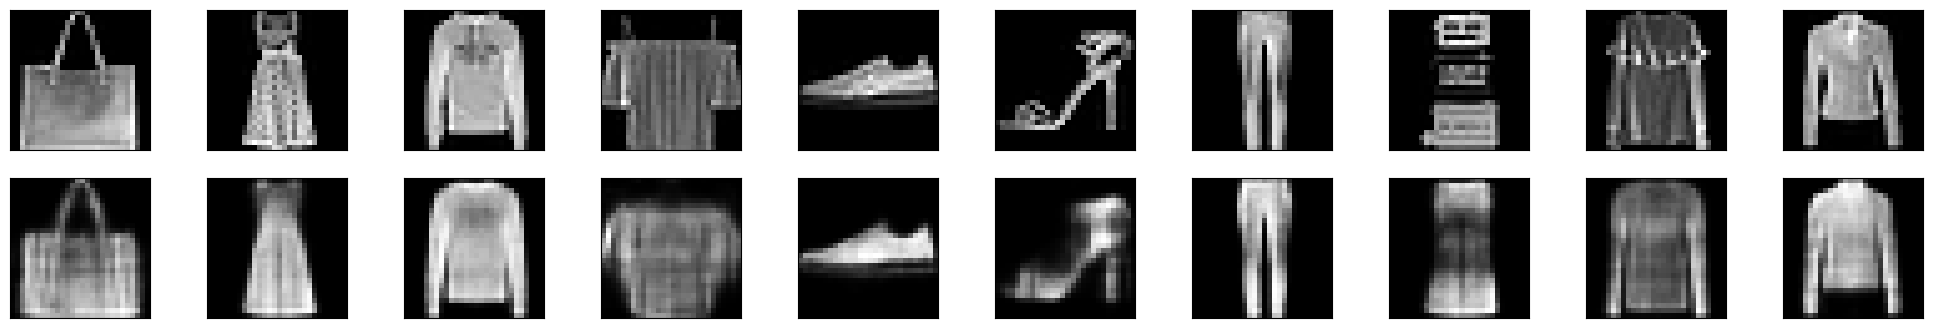

In [13]:
# Obtain one batch of test images
test_images, test_labels = next(iter(test_loader))

test_images_flatten = test_images.view(test_images.size(0), -1)
# Set model to evaluation mode
model.eval()
# Send model back to CPU
model.cpu()
# Get sample outputs
output = model(test_images_flatten)
# Prep images for display
test_images = test_images.numpy()

# Output is resized into a batch of images
output = output.view(batch_size, 1, 28, 28)
# Use detach when it's an output that requires_grad
output = output.detach().numpy()

# Plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# Input images on top row, reconstructions on bottom
for test_images, row in zip([test_images, output], axes):
    for img, ax in zip(test_images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)